In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

In [ ]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [ ]:
h = 0.001
x = 2/3
(f(x+h) - f(x))/h

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

In [ ]:
h = 0.001
d1 = a*b + c
a+=h
d2 = a*b + c
print("d1 ", d1)
print("d2 ", d2)
slope = (d2 - d1)/h
print("slope: ", slope)

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data,(self,other), '+')
        
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * (-1)
    
    def __sub__(self,other):
        #other = other if isinstance(other,Value) else Value(other)
        return self + (-other)
    
    def __radd__(self,other):
        return self+other
    
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self*other
    
    def __truediv__(self,other):
        out = self * other**-1
        return out
        
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other -1)) * out.grad
        out._backward = _backward
        
        return out
        
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) /(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        
    def backward(self):
        topo = [] 
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
a =Value(6)
b = Value(2)
a-2

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label = 'c')
e = a*b
e.label = 'e'
d =e + c
d.label = 'd'
f = Value(-2.0, label ='f')
L = d*f
L.label = 'L'
L

In [ ]:
#!pip install graphviz
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f  | grad %.4f}" % (n.label,n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
draw_dot(L)

In [ ]:
L.grad = 1
d.grad = f.data
f.grad = d.data
e.grad = c.grad = d.grad
a.grad = e.grad * b.data
b.grad = e.grad * a.data

In [ ]:
#tanh
val = np.arange(-5,5,0.1)
val_y = np.tanh(val)
plt.plot(val, val_y)
plt.grid()

In [ ]:
#sigmoid
val = np.arange(-5,5,0.1)
val_y = 1.0 / (1.0 + np.exp(-val))
plt.plot(val, val_y)
plt.grid()

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b= Value(6.88137, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#o = n.tanh(); o.label = 'o'

#implementing tanh in exp form
e = (2*n).exp() 
o = (e - 1)/(e + 1)

In [ ]:
o.backward()

In [ ]:
draw_dot(o)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print('---')
print('x2 ',x2.grad.item())
print('w2 ',w2.grad.item())
print('x1 ',x1.grad.item())
print('w1 ',w1.grad.item())
print(x1.dtype)

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a + b; label='d'
e = a * b; label='e'
f = d * e; label='f'
f.backward()
draw_dot(f)

In [52]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # x is input value
        # output is w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w,x)), self.b) # orignial output before activation
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        #out = [n(x) for n in self.layers]
        #return out
        for layer in self.layers:
            x = layer(x)
        return x
    
    def paramters(self):
        return [params for layer in self.layers for params in layer.parameters()]
    

#for layer in n.layers:
#    for neuron in layer.neurons:
#        print(neuron.w, neuron.b)
#    print()

In [106]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
out = n(x)


In [107]:
len(n.paramters())

41

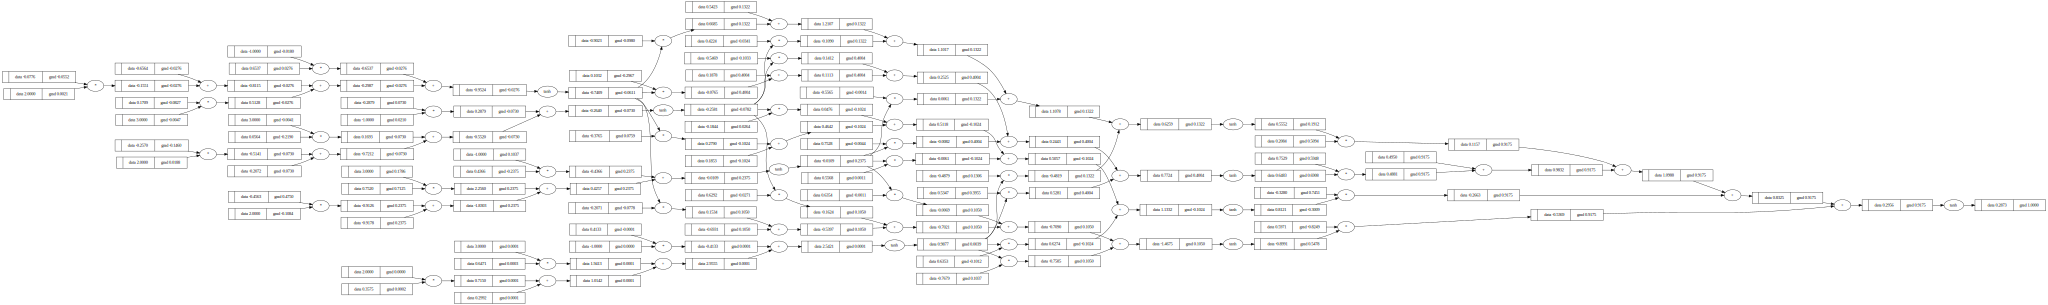

In [38]:
out.backward()
draw_dot(out)

In [110]:
xs =[
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]


In [458]:
for i in range(15):
    #forward pass
    y = [n(x) for x in xs]
    loss = sum((y2 - y1)**2 for y1,y2 in zip(ys, y))
    
    #backprop
    for p in n.paramters():
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in n.paramters():
        p.data += -0.1 * p.grad
    print(i, loss.data)

0 0.00024911010518532495
1 0.0002488457356117688
2 0.0002485819206994163
3 0.00024831865871168945
4 0.00024805594791924273
5 0.00024779378659990756
6 0.00024753217303867265
7 0.0002472711055276445
8 0.0002470105823659945
9 0.0002467506018599459
10 0.0002464911623227233
11 0.0002462322620745207
12 0.00024597389944244785
13 0.00024571607276053993
14 0.00024545878036966374


In [459]:
y

[Value(data=0.9928597012923542),
 Value(data=-0.9950218415940917),
 Value(data=-0.9905022547798474),
 Value(data=0.9910845252872318)]

In [295]:
loss

Value(data=0.0025892048548379343)

In [71]:
#if we use backprop on total output, we get grad for each term showing how it affects the total output
#similarly, backprop of loss will give grads that tell how each term affects final loss


Value(data=0.18707986223349599)

In [ ]:
draw_dot(loss)

In [ ]:
#if we want to increase output we increase value of each term in grad's dir (grad for output)
#similarly if we want to decrease the loss, we increase value of each term in opp dir of grad(here grad is for loss)

In [111]:
print(n.layers[0].neurons[0].w[0].grad, n.layers[0].neurons[0].w[0].data)

0 -0.22526111570636687
